Colormaps:
* PiYG, PRGn, BrBG, Puor, RoGy, RoBu, RoYIBu, RoYIGn, Spectral, coolwarm, bwr, seismic

In [1]:
import ipypb
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import torch
import radam
import torchaudio
import pytorch_lightning as pl

import dynamic_strf

device = torch.device('cuda:0')

logging.getLogger('radam').setLevel(logging.CRITICAL)
logging.getLogger('pytorch_lightning').setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.simplefilter('ignore')

In [2]:
top_db = 70
out_sr = 100
freqbins = 64
x_noisy = []
for i in range(19):
    sound, in_sr = torchaudio.load(f'Data/Sounds/stim{i+1}.flac')
    spect = dynamic_strf.modeling.SpectrogramParser(
        in_sr, out_sr, freqbins, f_max=11025/2, normalize=False
    )(sound)
    x_noisy.append(spect)

y_noisy = []
path_fmt = 'Data/LIJ%s_data_TrainOn1If2Records.mat'
for subj_id in ['109', '110', '112', '113', '114', '120']:
    y_noisy.append(loadmat(path_fmt % subj_id)['noisy_resp'].squeeze(0))
y_noisy = [torch.cat([torch.from_numpy(y[i]) for y in y_noisy], dim=1) for i in range(19)]

for i in range(19):
    diff = len(x_noisy[i]) - len(y_noisy[i])
    if diff == 1:
        x_noisy[i] = x_noisy[i][:-1]
    elif diff > 1:
        raise RuntimeError(f'X and Y have different lengths for stim{i+1}!')
    
    x_noisy[i] = x_noisy[i][100:-50].float()
    y_noisy[i] = y_noisy[i][100:-50].float()

x_noisy = x_noisy[:-1]
y_noisy = y_noisy[:-1]

channels = y_noisy[0].shape[1]

In [3]:
def builder():
    return dynamic_strf.modeling.SharedEncoder(
        input_size=freqbins,
        hidden_size=128,
        channels=channels
    ).to(device)

model = builder().to(device)

scores0 = dynamic_strf.modeling.test_multiple(
    model=model,
    checkpoints='5x128-cv',
    data=(x_noisy[:1], y_noisy[:1]),
    crossval=True,
    jackknife_mode='score',
    verbose=0,
)[0]

scores1 = dynamic_strf.modeling.test_multiple(
    model=model,
    checkpoints='5x128-jackknife-cv',
    data=(x_noisy[:1], y_noisy[:1]),
    crossval=True,
    jackknife_mode='score',
    verbose=0,
)[0]

scores2 = dynamic_strf.modeling.test_multiple(
    model=model,
    checkpoints='5x128-jackknife-cv',
    data=(x_noisy[:1], y_noisy[:1]),
    crossval=True,
    jackknife_mode='pred',
    verbose=0
)[0]

preds0 = dynamic_strf.modeling.infer_multiple(
    model=model,
    checkpoints='5x128-cv',
    data=x_noisy[:1],
    crossval=True,
    jackknife_mode='pred',
    verbose=0,
)[0]

preds1 = dynamic_strf.modeling.infer_multiple(
    model=model,
    checkpoints='5x128-jackknife-cv',
    data=x_noisy[:1],
    crossval=True,
    jackknife_mode='pred',
    verbose=0,
)[0]

In [4]:
pred = loadmat('strf_and_dnn_preds_firststim.mat')['dnn_preds_firststim'].squeeze(0)
pred = torch.from_numpy(np.concatenate(pred[[3,4,5,0,1,2]], axis=0).T[100:-50])
dnn_scores = dynamic_strf.utils.corr(pred, y_noisy[0], axis=0)

pred = loadmat('strf_and_dnn_preds_firststim.mat')['strf_preds_firststim'].squeeze(0)
pred = torch.from_numpy(np.concatenate(pred[[3,4,5,0,1,2]], axis=0).T[100:-50])
strf_scores = dynamic_strf.utils.corr(pred, y_noisy[0], axis=0)

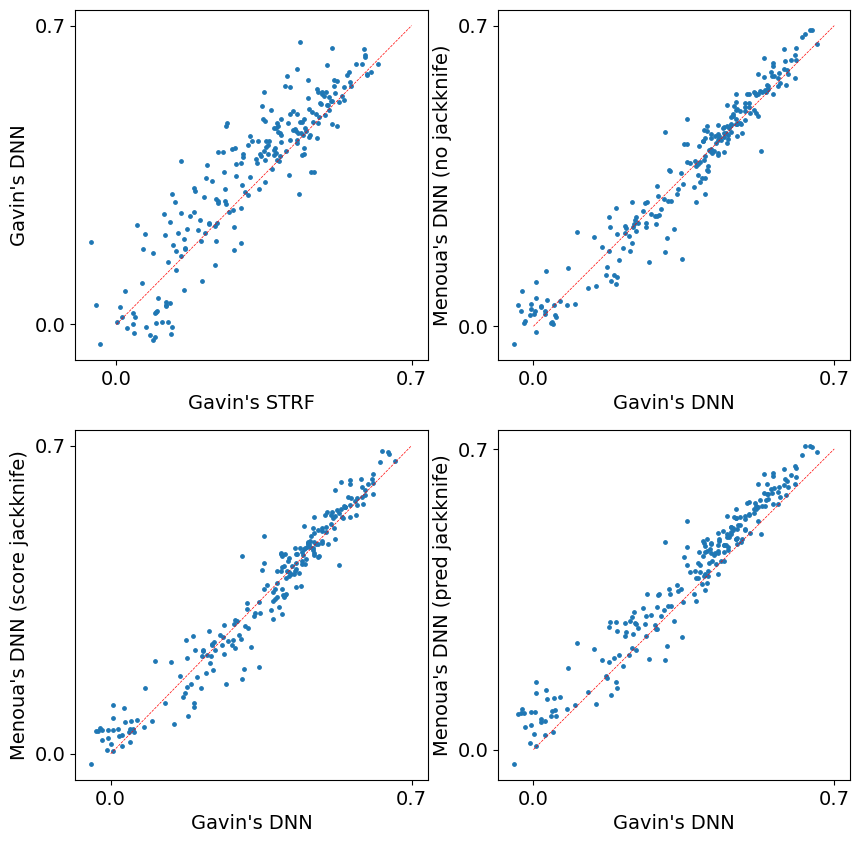

In [5]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.scatter(strf_scores, dnn_scores, 6)
plt.plot([0, 0.7], [0, 0.7], 'r--', linewidth=0.5)
plt.xticks([0, 0.7], fontsize=14)
plt.yticks([0, 0.7], fontsize=14)
plt.xlabel('Gavin\'s STRF', fontsize=14)
plt.ylabel('Gavin\'s DNN', fontsize=14)

plt.subplot(222)
plt.scatter(dnn_scores, scores0, 6)
plt.plot([0, 0.7], [0, 0.7], 'r--', linewidth=0.5)
plt.xticks([0, 0.7], fontsize=14)
plt.yticks([0, 0.7], fontsize=14)
plt.xlabel('Gavin\'s DNN', fontsize=14)
plt.ylabel('Menoua\'s DNN (no jackknife)', fontsize=14)

plt.subplot(223)
plt.scatter(dnn_scores, scores1, 6)
plt.plot([0, 0.7], [0, 0.7], 'r--', linewidth=0.5)
plt.xticks([0, 0.7], fontsize=14)
plt.yticks([0, 0.7], fontsize=14)
plt.xlabel('Gavin\'s DNN', fontsize=14)
plt.ylabel('Menoua\'s DNN (score jackknife)', fontsize=14)

plt.subplot(224)
plt.scatter(dnn_scores, scores2, 6)
plt.plot([0, 0.7], [0, 0.7], 'r--', linewidth=0.5)
plt.xticks([0, 0.7], fontsize=14)
plt.yticks([0, 0.7], fontsize=14)
plt.xlabel('Gavin\'s DNN', fontsize=14)
plt.ylabel('Menoua\'s DNN (pred jackknife)', fontsize=14)

plt.show()

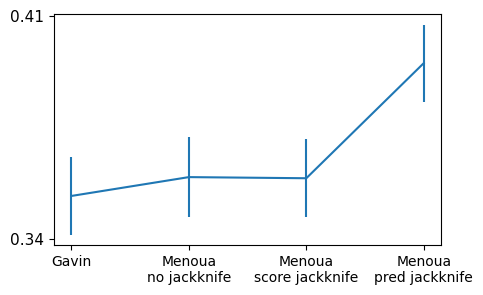

In [6]:
plt.figure(figsize=(5, 3))

plt.errorbar(
    [1, 2, 3, 4],
    [dnn_scores.mean(), scores0.mean(), scores1.mean(), scores2.mean()],
    [dnn_scores.std()/np.sqrt(channels), scores0.std()/np.sqrt(channels), scores1.std()/np.sqrt(channels), scores2.std()/np.sqrt(channels)],
)
plt.xticks([1, 2, 3, 4], ['Gavin', 'Menoua\nno jackknife', 'Menoua\nscore jackknife', 'Menoua\npred jackknife'])
plt.yticks([0.34, 0.41], fontsize=11)

plt.show()